Задача 8.3. Рассмотреть модельную задачу из статьи 2.pdf. (Sect. B One-Dimensional Non-linear Example With Additive Gaussian Noise). Построить EKF и фильтр второго порядка. Сделать 1 расчет. На графиках (отдельных для каждой компоненты состояния) выводить точное значение 𝑋, оценку 𝑋̂(𝑡) EKF, оценку СКО ошибки EKF √𝑘(𝑡), оценку 𝑋̂(𝑡) EKF 2го порядка, оценку СКО ошибки EKF 2го порядка √𝑘(𝑡).

Consider the scalar nonlinear system described by
X_k = psi_1 * X_k-1 + psi_2 * X_k-1^2 + 8 * cos(w * k) + v_k

where v_k is zero-mean Gaussian white noise with variance
10; w = 1.2, psi1 = 0.2, and psi_2 = 0.01 are scalar parameters.

We consider the same problem as described in the
first example, but this time the process noise vk is
assumed to be distributed as a heavy-tailed gamma function and given by v_k = Г(3,2), where  denotes the
gamma distribution. The observation noise wk is assumed
to be zero-mean Gaussian with variance 0.01

In [1]:
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

In [2]:
psi_1, psi_2, w, T = (0.2, 0.01, 1.2, 100)

In [3]:
def a_func(psi_1, psi_2, w, X, i):
  return psi_1 * X[i - 1]  + psi_2 * (X[i - 1] ** 2) + 8. * np.cos(w * i)

def a_func_pr(psi_1, psi_2, X, i):
  return psi_1 + 2. * psi_2 * X[i - 1]

def a_func_pr_2(psi_2):
  return 2. * psi_2

def A_func(X):
  return X ** 2

def A_func_pr(X):
  return 2. * X

def A_func_pr_2():
  return 2.

In [4]:
V_0, W_0 = (np.random.gamma(shape = 3, scale = 2.0), np.random.normal(loc = 0.0, scale = 0.01))
X_0 = np.random.uniform(size=1)
Y_0 = A_func(X_0[0]) + W_0
X_0 = X_0[0]

In [5]:
def create_real(psi_1, psi_2, w, X_0, Y_0, T):
  X, Y = [X_0], [Y_0]
  W = np.random.normal(loc = 0.0, scale = 0.01, size = T - 1)
  V = np.random.gamma(shape = 3, scale = 2.0, size = T - 1)
  for i in range(1, T):
    X.append(a_func(psi_1, psi_2, w, X, i) + V[i - 1])
    Y.append(A_func(X[i]) + W[i - 1])
  return X, Y

In [6]:
X, Y = create_real(psi_1, psi_2, w, X_0, Y_0, T)

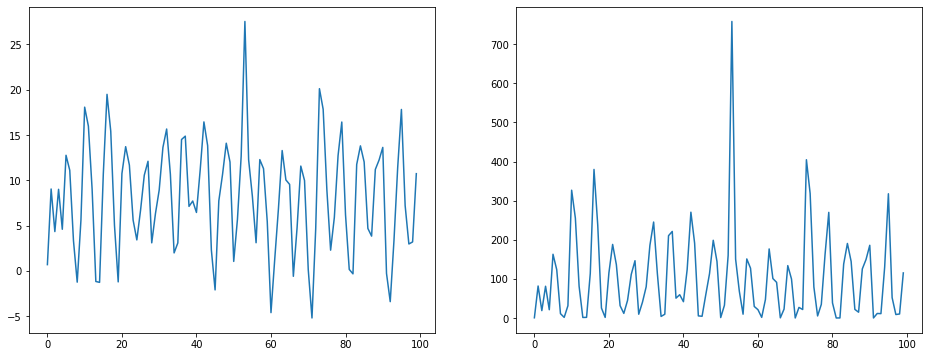

In [7]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
axes[0].plot(np.arange(0, T), X)
axes[1].plot(np.arange(0, T), Y)

In [8]:
def forec(psi_1, psi_2, w, X, k, i):
  X_for = a_func(psi_1, psi_2, w, X, i) + 0.5 * a_func_pr_2(psi_2) * k
  k_for = (a_func_pr(psi_1, psi_2, X, i) ** 2) * k + 0.5 * (a_func_pr_2(psi_2) ** 2) * (k ** 2) + 1.**2 # b = 1.
  return X_for, k_for

def forec_Y(X_for, k_for):
  Y_for = A_func(X_for) + 0.5 * A_func_pr_2() * k_for
  q_for = (A_func_pr(X_for) ** 2) * k_for + 0.5 * (A_func_pr_2() ** 2) * k_for
  return Y_for, q_for

In [9]:
def correc(X_for, k_for, Y_for, q_for, Y, i):
  X_cor = X_for + k_for * A_func_pr(X_for) * (1. / q_for) * (Y - Y_for)
  k_cor = k_for - k_for * (A_func_pr(X_for) ** 2) * (1. / q_for) * k_for
  return X_cor, k_cor

In [10]:
def make_pred(psi_1, psi_2, w, X_pred_0, k_pred_0, Y, T):
  X_pred_t = [X_pred_0]
  k_pred_t = [k_pred_0]
  for i in tqdm(range(1, T)):
    X_for, k_for = forec(psi_1, psi_2, w, X_pred_t, k_pred_t[i - 1], i)
    Y_for, q_for = forec_Y(X_for, k_for)
    X_cor, k_cor = correc(X_for, k_for, Y_for, q_for, Y[i], i)
    X_pred_t.append(X_cor)
    k_pred_t.append(k_cor)
  return X_pred_t, k_pred_t

In [11]:
X_pred_0, k_pred_0 = (0.5, 2)
X_pred_t, k_pred_t = make_pred(psi_1, psi_2, w, X_pred_0, k_pred_0, Y, T)

100%|██████████| 99/99 [00:00<00:00, 59901.34it/s]


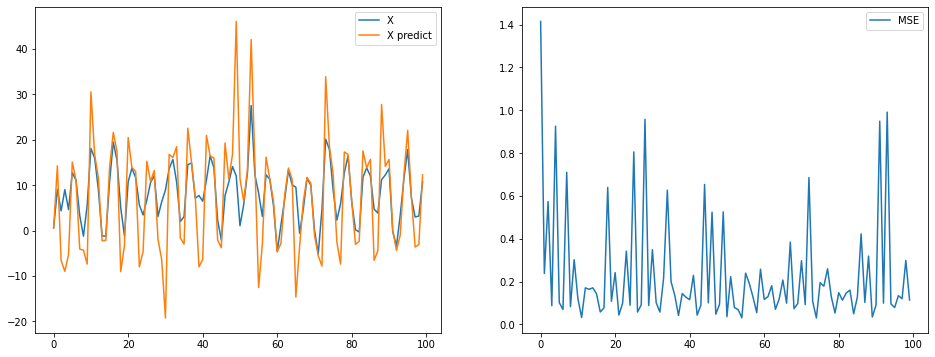

In [20]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
axes[0].plot(np.arange(0, T), X, label='X')
axes[0].plot(np.arange(0, T), X_pred_t, label='X predict')
axes[0].legend()
axes[1].plot(np.arange(0, T), np.sqrt(k_pred_t), label='MSE')
axes[1].legend()

In [16]:
def forec_lin(psi_1, psi_2, w, X, k, i):
  X_for = a_func(psi_1, psi_2, w, X, i)
  k_for = (a_func_pr(psi_1, psi_2, X, i) ** 2) * k + 1. ** 2 # b = 1.
  return X_for, k_for

def correc_lin(X_for, k_for, Y, i):
  X_cor = X_for + k_for * A_func_pr(X_for) * (1. / ((A_func_pr(X_for) ** 2) * k_for + (1. ** 2))) * (Y - A_func(X_for))
  k_cor = k_for - k_for * A_func(X_for) * (1. / ((A_func_pr(X_for) ** 2) * k_for + (1 ** 2)))
  return X_cor, k_cor

In [17]:
def make_pred_lin(psi_1, psi_2, w, X_pred_lin_0, k_pred_lin_0, Y, T):
  X_pred_lin_t = [X_pred_lin_0]
  k_pred_lin_t = [k_pred_lin_0]
  for i in tqdm(range(1, T)):
    X_for, k_for = forec_lin(psi_1, psi_2, w, X_pred_lin_t, k_pred_lin_t[i - 1], i)
    X_cor, k_cor = correc_lin(X_for, k_for, Y[i], i)
    X_pred_lin_t.append(X_cor)
    k_pred_lin_t.append(k_cor)
  return X_pred_lin_t, k_pred_lin_t

In [18]:
X_pred_lin_0, k_pred_lin_0 = (0.5, 2)
X_pred_lin_t, k_pred_lin_t = make_pred_lin(psi_1, psi_2, w, X_pred_lin_0, k_pred_lin_0, Y, T)

100%|██████████| 99/99 [00:00<00:00, 80644.03it/s]


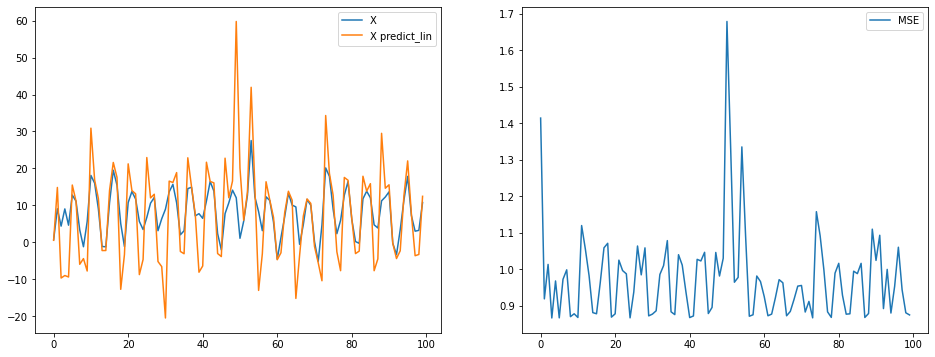

In [19]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
axes[0].plot(np.arange(0, T), X, label='X')
axes[0].plot(np.arange(0, T), X_pred_lin_t, label='X predict_lin')
axes[0].legend()
axes[1].plot(np.arange(0, T), np.sqrt(k_pred_lin_t), label='MSE')
axes[1].legend()